# Volatility Breakout (VBO) Strategy Backtesting

이 노트북은 VBO 전략의 백테스팅과 분석을 위한 것입니다.

## 주요 기능
- Vanilla VBO 전략 실행
- 다양한 필터/조건 조합 테스트
- 전략 비교 분석
- 성과 리포트 생성

In [1]:
# Setup and imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

from src.strategies.volatility_breakout.filters import NoiseThresholdFilter, VolatilityFilter

from src.backtester import BacktestConfig, generate_report, run_backtest
from src.config import REPORTS_DIR
from src.strategies.volatility_breakout import VanillaVBO, create_vbo_strategy
from src.strategies.volatility_breakout.conditions import VolatilityThresholdCondition
from src.utils.logger import setup_logging

# Setup logging
setup_logging()

# Ensure reports directory exists
REPORTS_DIR.mkdir(exist_ok=True)

print("Setup complete!")

Setup complete!


## 1. Vanilla VBO Strategy

기본 설정으로 VBO 전략을 실행합니다.

In [2]:
# Vanilla VBO with default settings
strategy = VanillaVBO(
    sma_period=4,
    trend_sma_period=8,
    short_noise_period=4,
    long_noise_period=8,
)

print(f"Strategy: {strategy}")
print(f"Entry Conditions: {[c.name for c in strategy.entry_conditions.conditions]}")
print(f"Exit Conditions: {[c.name for c in strategy.exit_conditions.conditions]}")
print(f"Filters: {[f.name for f in strategy.filters.filters]}")

config = BacktestConfig(
    initial_capital=1.0,
    fee_rate=0.0005,
    slippage_rate=0.0005,
    max_slots=4,
)

tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-TRX"]

result = run_backtest(
    strategy=strategy,
    tickers=tickers,
    interval="day",
    config=config,
)

print(result.summary())

Strategy: VanillaVBO(name='VanillaVBO', entry_conditions=2, exit_conditions=1, filters=2)
Entry Conditions: ['Breakout', 'SMABreakout']
Exit Conditions: ['PriceBelowSMA']
Filters: ['TrendFilter', 'NoiseFilter']

Strategy: VanillaVBO
CAGR: 65.14%
MDD: 24.85%
Calmar Ratio: 2.62
Sharpe Ratio: 1.66
Win Rate: 37.59%
Total Trades: 846
Final Equity: 63.7361


## 2. Minimal VBO (No Filters)

필터 없이 기본 조건만 사용하는 VBO 전략입니다.

In [3]:
# VBO without filters (baseline comparison)
strategy = create_vbo_strategy(
    name="MinimalVBO",
    use_trend_filter=False,
    use_noise_filter=False,
)

print(f"Strategy: {strategy}")
print(f"Filters: {[f.name for f in strategy.filters.filters]}")

config = BacktestConfig(max_slots=4)
tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-TRX"]

result = run_backtest(
    strategy=strategy,
    tickers=tickers,
    interval="day",
    config=config,
)

print(result.summary())

Strategy: VanillaVBO(name='MinimalVBO', entry_conditions=2, exit_conditions=1, filters=0)
Filters: []

Strategy: MinimalVBO
CAGR: 18.96%
MDD: 75.38%
Calmar Ratio: 0.25
Sharpe Ratio: 0.62
Win Rate: 26.77%
Total Trades: 1898
Final Equity: 4.2112


## 3. Custom VBO with Extra Conditions

추가 조건과 필터를 적용한 커스텀 VBO 전략입니다.

In [4]:
# Custom VBO with additional conditions
strategy = create_vbo_strategy(
    name="CustomVBO_Strict",
    extra_entry_conditions=[
        VolatilityThresholdCondition(min_range_pct=0.01),
    ],
    extra_filters=[
        NoiseThresholdFilter(max_noise=0.65),
    ],
)

print(f"Strategy: {strategy}")
print(f"Entry Conditions: {[c.name for c in strategy.entry_conditions.conditions]}")
print(f"Filters: {[f.name for f in strategy.filters.filters]}")

config = BacktestConfig(max_slots=4)
tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-TRX"]

result = run_backtest(
    strategy=strategy,
    tickers=tickers,
    interval="day",
    config=config,
)

print(result.summary())

Strategy: VanillaVBO(name='CustomVBO_Strict', entry_conditions=3, exit_conditions=1, filters=3)
Entry Conditions: ['Breakout', 'SMABreakout', 'VolatilityThreshold']
Filters: ['TrendFilter', 'NoiseFilter', 'NoiseThresholdFilter']

Strategy: CustomVBO_Strict
CAGR: 67.10%
MDD: 20.62%
Calmar Ratio: 3.25
Sharpe Ratio: 1.72
Win Rate: 39.84%
Total Trades: 763
Final Equity: 70.2615


## 4. Dynamic Strategy Modification

전략을 동적으로 수정하는 예제입니다.

In [5]:
# Start with vanilla strategy
strategy = VanillaVBO(name="DynamicVBO")
print(f"Initial filters: {[f.name for f in strategy.filters.filters]}")

# Remove noise filter
noise_filter = strategy.filters.filters[1]  # NoiseFilter
strategy.remove_filter(noise_filter)
print(f"After removing NoiseFilter: {[f.name for f in strategy.filters.filters]}")

# Add volatility filter
vol_filter = VolatilityFilter(min_volatility_pct=0.005)
strategy.add_filter(vol_filter)
print(f"After adding VolatilityFilter: {[f.name for f in strategy.filters.filters]}")

config = BacktestConfig(max_slots=4)
tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-TRX"]

result = run_backtest(
    strategy=strategy,
    tickers=tickers,
    interval="day",
    config=config,
)

print(result.summary())

Initial filters: ['TrendFilter', 'NoiseFilter']
After removing NoiseFilter: ['TrendFilter']
After adding VolatilityFilter: ['TrendFilter', 'VolatilityFilter']

Strategy: DynamicVBO
CAGR: 38.05%
MDD: 61.76%
Calmar Ratio: 0.62
Sharpe Ratio: 1.02
Win Rate: 29.59%
Total Trades: 1433
Final Equity: 14.4477


## 5. Strategy Comparison

여러 전략 구성을 비교 분석합니다.

In [6]:
# Compare multiple strategy configurations
strategies = [
    create_vbo_strategy(
        name="VBO_AllFilters",
        use_trend_filter=True,
        use_noise_filter=True,
    ),
    create_vbo_strategy(
        name="VBO_TrendOnly",
        use_trend_filter=True,
        use_noise_filter=False,
    ),
    create_vbo_strategy(
        name="VBO_NoiseOnly",
        use_trend_filter=False,
        use_noise_filter=True,
    ),
    create_vbo_strategy(
        name="VBO_NoFilters",
        use_trend_filter=False,
        use_noise_filter=False,
    ),
]

config = BacktestConfig(max_slots=4)
tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-TRX"]

results = []
for strategy in strategies:
    result = run_backtest(
        strategy=strategy,
        tickers=tickers,
        interval="day",
        config=config,
    )
    results.append(result)

# Print comparison table
print("\n" + "-" * 70)
print(f"{'Strategy':<20} {'CAGR':>10} {'MDD':>10} {'Calmar':>10} {'Trades':>10}")
print("-" * 70)

for result in results:
    print(
        f"{result.strategy_name:<20} "
        f"{result.cagr:>9.2f}% "
        f"{result.mdd:>9.2f}% "
        f"{result.calmar_ratio:>10.2f} "
        f"{result.total_trades:>10}"
    )


----------------------------------------------------------------------
Strategy                   CAGR        MDD     Calmar     Trades
----------------------------------------------------------------------
VBO_AllFilters           65.14%     24.85%       2.62        846
VBO_TrendOnly            37.94%     62.91%       0.60       1447
VBO_NoiseOnly            58.09%     33.89%       1.71       1088
VBO_NoFilters            18.96%     75.38%       0.25       1898


## 6. Full Performance Report

상세한 성과 리포트와 시각화를 생성합니다.


  BACKTEST REPORT: VBO_FullReport

[Period]
   Start Date:     2017-09-25
   End Date:       2026-01-04
   Total Days:     3,023

[Returns]
   Total Return:   6,273.61%
   CAGR:           65.14%

[Risk]
   Max Drawdown:   24.85%
   Volatility:     33.56%

[Risk-Adjusted Returns]
   Sharpe Ratio:   1.66
   Sortino Ratio:  2.95
   Calmar Ratio:   2.62

[Trade Statistics]
   Total Trades:   846
   Winning:        318
   Losing:         528
   Win Rate:       37.59%
   Profit Factor:  1.68

[Per-Trade]
   Avg Profit:     11.67%
   Avg Loss:       -3.10%
   Avg Trade:      2.45%




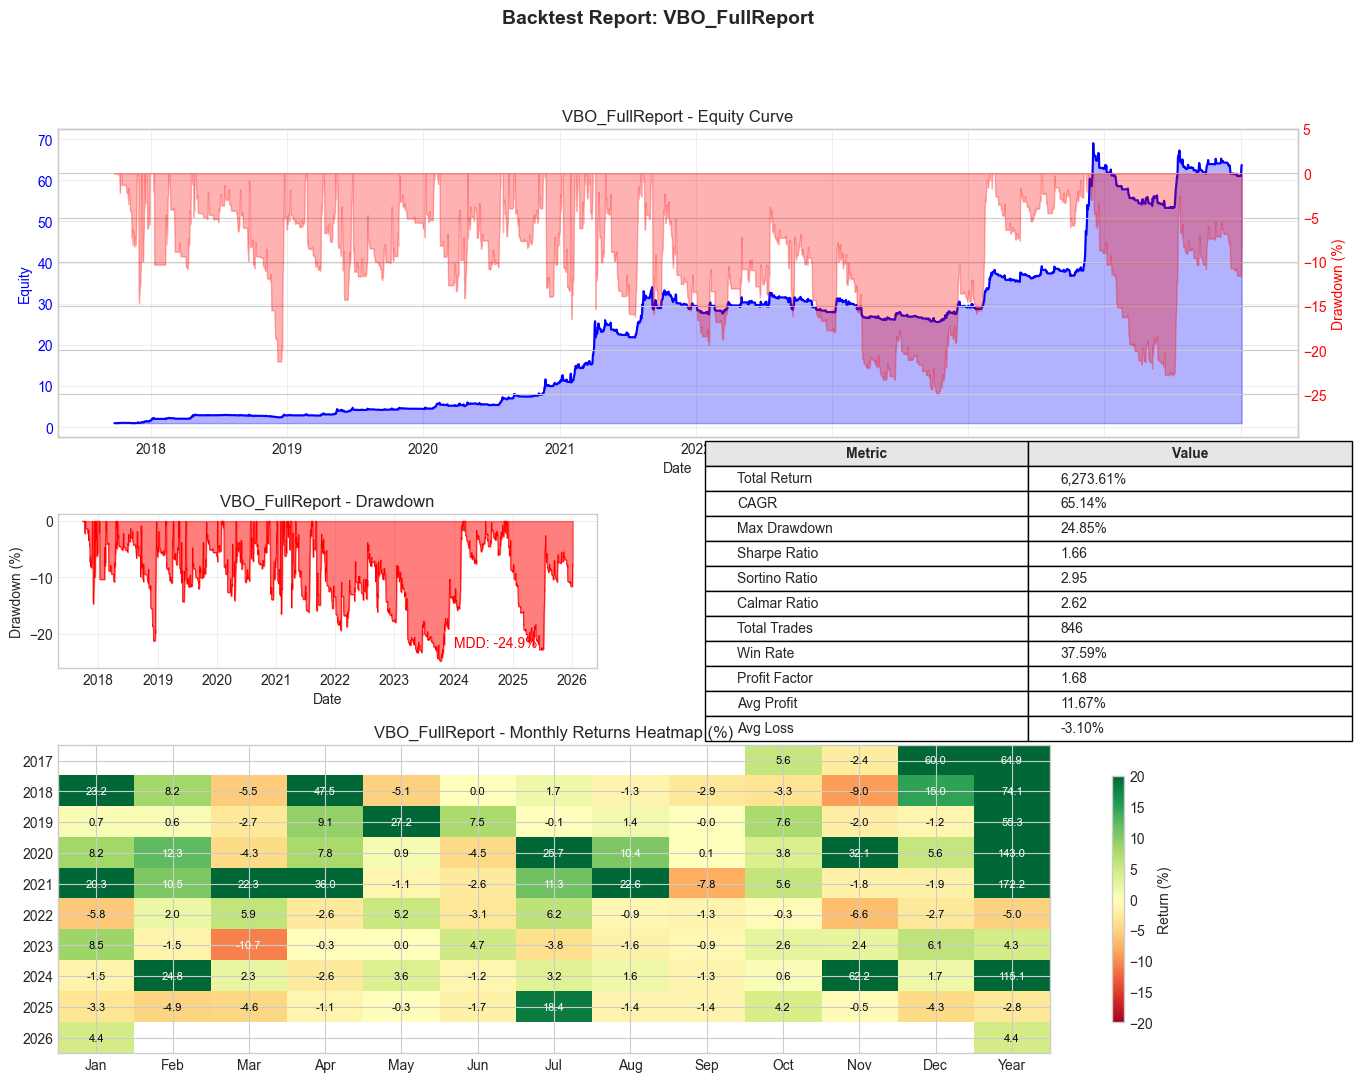


[+] Report saved to: C:\dev\upbit-quant-system\reports
    - vbo_report.png
    - vbo_metrics.csv


In [7]:
# Run VBO with full performance report
strategy = VanillaVBO(
    name="VBO_FullReport",
    sma_period=4,
    trend_sma_period=8,
    short_noise_period=4,
    long_noise_period=8,
)

config = BacktestConfig(
    initial_capital=1.0,
    fee_rate=0.0005,
    slippage_rate=0.0005,
    max_slots=4,
)

tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-TRX"]

result = run_backtest(
    strategy=strategy,
    tickers=tickers,
    interval="day",
    config=config,
)

# Generate full report with visualizations
save_path = REPORTS_DIR / "vbo_report.png"

report = generate_report(
    result=result,
    save_path=save_path,
    show=True,
)

# Export metrics to CSV
metrics_df = report.to_dataframe()
metrics_df.to_csv(REPORTS_DIR / "vbo_metrics.csv", index=False)
print(f"\n[+] Report saved to: {REPORTS_DIR}")
print("    - vbo_report.png")
print("    - vbo_metrics.csv")

## 7. Additional Analysis

추가 분석을 위한 셀입니다. 필요에 따라 수정하여 사용하세요.

Total Return: 6273.61%
CAGR: 65.14%
Sharpe Ratio: 1.66
Sortino Ratio: 2.95
Max Drawdown: 24.85%
Win Rate: 37.59%
Profit Factor: 1.68


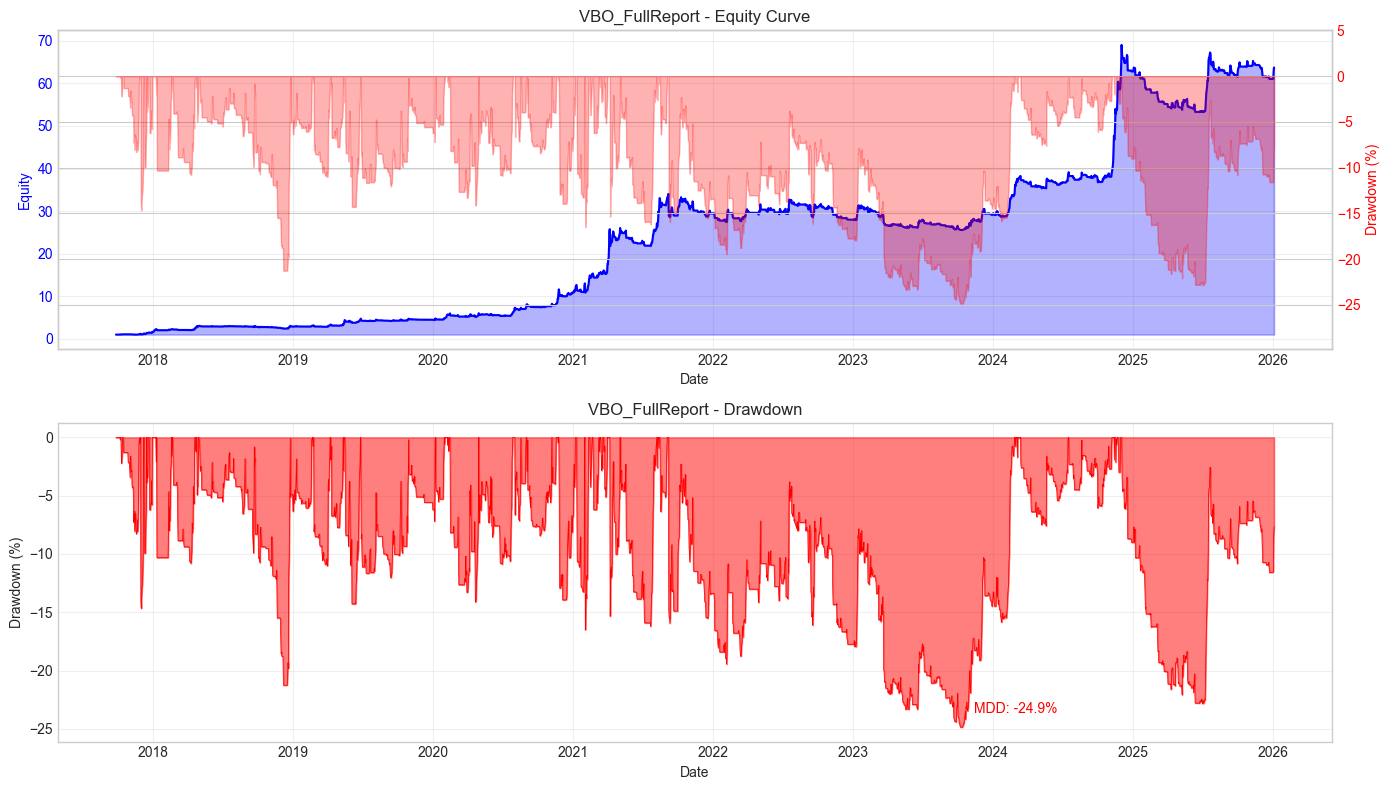

In [8]:
# Example: Access individual metrics
print(f"Total Return: {report.metrics.total_return_pct:.2f}%")
print(f"CAGR: {report.metrics.cagr_pct:.2f}%")
print(f"Sharpe Ratio: {report.metrics.sharpe_ratio:.2f}")
print(f"Sortino Ratio: {report.metrics.sortino_ratio:.2f}")
print(f"Max Drawdown: {report.metrics.mdd_pct:.2f}%")
print(f"Win Rate: {report.metrics.win_rate_pct:.2f}%")
print(f"Profit Factor: {report.metrics.profit_factor:.2f}")

# Example: Plot individual charts
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
report.plot_equity_curve(ax=axes[0], show_drawdown=True)
report.plot_drawdown(ax=axes[1])
plt.tight_layout()
plt.show()